<img alt="https://allisonhorst.github.io/palmerpenguins/" src="https://raw.githubusercontent.com/allisonhorst/palmerpenguins/master/man/figures/lter_penguins.png" width=60% />

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

In [2]:
penguins = pd.read_csv("https://github.com/allisonhorst/palmerpenguins/raw/5b5891f01b52ae26ad8cb9755ec93672f49328a8/data/penguins_size.csv")
penguins.head()

species_short     island  culmen_length_mm  culmen_depth_mm  \
0        Adelie  Torgersen              39.1             18.7   
1        Adelie  Torgersen              39.5             17.4   
2        Adelie  Torgersen              40.3             18.0   
3        Adelie  Torgersen               NaN              NaN   
4        Adelie  Torgersen              36.7             19.3   

   flipper_length_mm  body_mass_g     sex  
0              181.0       3750.0    MALE  
1              186.0       3800.0  FEMALE  
2              195.0       3250.0  FEMALE  
3                NaN          NaN     NaN  
4              193.0       3450.0  FEMALE

# PCA

## Q

Remove the undefined values and get the sample size for each species.

## A

In [3]:
penguins = penguins.dropna()
penguins.species_short.value_counts()

species_short
Adelie       146
Gentoo       120
Chinstrap     68
Name: count, dtype: int64

## Q

Plot a `pairplot` so that each species can be distinguished by a different color.

## A

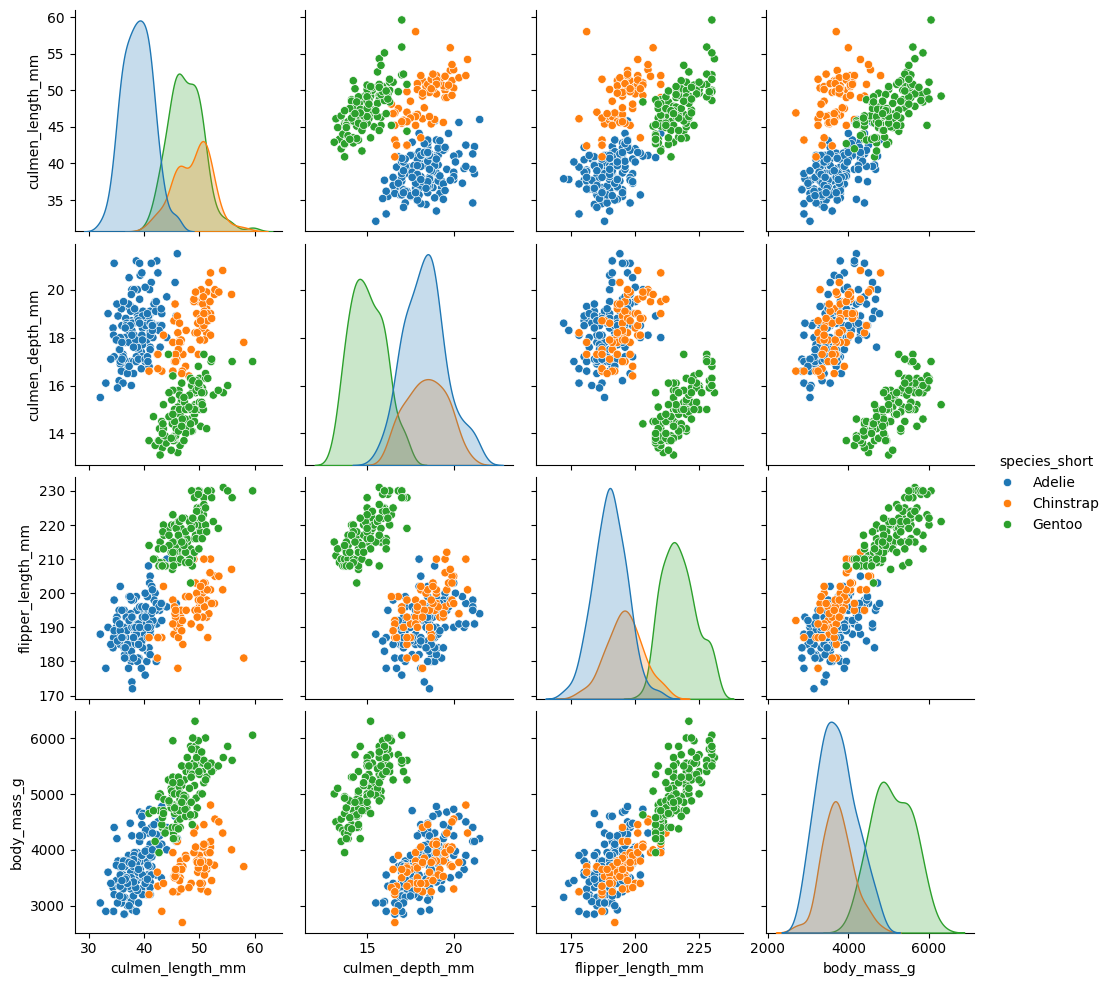

In [4]:
sns.pairplot(penguins, hue='species_short');

## Q

Pick the continuous variables, standardize their values and perform a PCA on the scaled data, with as many components as possible.

Draw a scree plot to choose a number of principal components.

## A

In [5]:
penguin_data = penguins[[
    "culmen_length_mm",
    "culmen_depth_mm",
    "flipper_length_mm",
    "body_mass_g",
]].values

from sklearn.preprocessing import StandardScaler

scaled_penguin_data = StandardScaler().fit_transform(penguin_data)

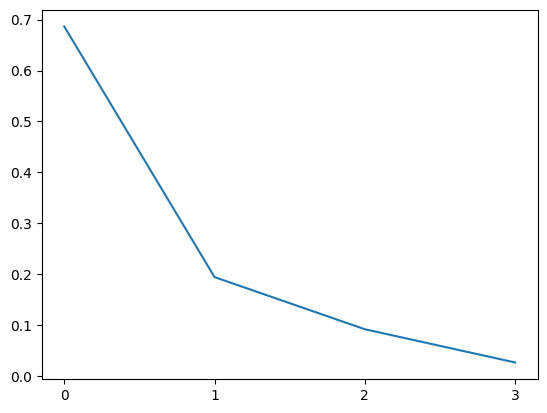

In [6]:
from sklearn import decomposition

pca = decomposition.PCA()
pca.fit(scaled_penguin_data)

ax = sns.lineplot(pca.explained_variance_ratio_)
ax.set_xticks(range(4));

## Q

Perform a new PCA with a number of principal components, projects the data onto the principal axes, and plot the final data representing each species with a different color (hint: look at [this plotting function](https://plotly.github.io/plotly.py-docs/generated/plotly.express.scatter_3d.html)).

## A

In [7]:
pca = decomposition.PCA(n_components='mle')
pca.fit(scaled_penguin_data)
pca.n_components_

3

In [8]:
projected_data = pca.transform(scaled_penguin_data)
projected_data.shape

(334, 3)

Easy way:

In [9]:
projected_data_ = pd.DataFrame({
    'first PC': projected_data[:,0],
    'second PC': projected_data[:,1],
    'third PC': projected_data[:,2],
    'species': penguins.species_short,
})

In [10]:
import nbformat
print(nbformat.__version__)

5.10.4


In [11]:
fig = px.scatter_3d(
    data_frame=projected_data_,
    x='first PC',
    y='second PC',
    z='third PC',
    color='species',
)
fig.update_traces(
    marker=dict(size=3, line=dict(width=1)),
)
fig

Hard way (required for composing with multiple subplots):

In [12]:
fig = go.Figure()

for species in np.unique(penguins.species_short):
    species_data = projected_data[penguins.species_short == species, :]
    fig.add_trace(go.Scatter3d(
        name=species,
        x=species_data[:,0],
        y=species_data[:,1],
        z=species_data[:,2],
        mode='markers',
        marker=dict(size=3, line=dict(width=1)),
    ))
    
fig.update_scenes(
    xaxis_title='first PC',
    yaxis_title='second PC',
    zaxis_title='third PC',
)
fig.show()

# UMAP

## Q

Plot a 2D UMAP projection of the scaled penguin data (continuous variables, one penguin = one dot), and color the dots by species.

## A

In [13]:
import umap

In [14]:
projected_data = umap.UMAP(
    n_neighbors=10,
    min_dist=1.,
).fit_transform(scaled_penguin_data)

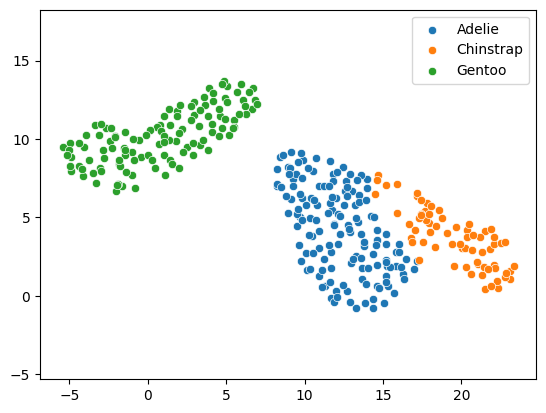

In [15]:
for species in np.unique(penguins.species_short):
    species_data = projected_data[penguins.species_short == species, :]
    ax = sns.scatterplot(
        x=species_data[:,0],
        y=species_data[:,1],
        label=species,
    )
ax.set_aspect('equal', 'datalim');

## Q

Adelie and Chinstrap penguins look more difficult to separate. To quantify how separated are the two corresponding clouds of points, we can use the silhouette score applied to the projected data for Adelie and Chinstrap penguins only.

In [16]:
from sklearn.metrics import silhouette_score

Find the combination of values that maximizes the above score, using a grid search with neighbor counts 2, 3, 5, 10, 20, 30, 50, 100 and minimum distances 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0.

## A

Our parameter grid:

In [17]:
param_grid = {'n_neighbors': [2, 3, 5, 10, 20, 30, 50, 100], 'min_dist': np.arange(.1, 1.1, .1)}
param_grid

{'n_neighbors': [2, 3, 5, 10, 20, 30, 50, 100],
 'min_dist': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}

Our objective function:

In [18]:
adelie = penguins.species_short == 'Adelie'
chinstrap = penguins.species_short == 'Chinstrap'

In [19]:
def adelie_chinstrap_silhouette(projected_data):
    x = projected_data[adelie, :]
    y = projected_data[chinstrap, :]
    score = silhouette_score(np.vstack((x, y)), np.repeat([0, 1], [x.shape[0], y.shape[0]]))
    return score

or, very similarly:

In [20]:
adelie_or_chinstrap = np.logical_or(adelie, chinstrap)

labels = np.zeros(adelie_or_chinstrap.shape, dtype=int)
labels[chinstrap] = 1
labels = labels[adelie_or_chinstrap]

In [21]:
def adelie_chinstrap_silhouette(projected_data):
    xy = projected_data[adelie_or_chinstrap, :]
    score = silhouette_score(xy, labels)
    return score

Run the exhaustive grid search (takes time):

In [ ]:
grid_n_neighbors = []
grid_min_dist = []
grid_scores = []

for n_neighbors in param_grid['n_neighbors']:
    for min_dist in param_grid['min_dist']:
        
        embedding = umap.UMAP(
            n_neighbors=n_neighbors,
            min_dist=min_dist,
        ).fit(scaled_penguin_data)
        projected_data = embedding.transform(scaled_penguin_data)
        score = adelie_chinstrap_silhouette(projected_data)
        
        grid_n_neighbors.append(n_neighbors)
        grid_min_dist.append(min_dist)
        grid_scores.append(score)

In [ ]:
grid_results = pd.DataFrame({'n_neighbors': grid_n_neighbors, 'min_dist': grid_min_dist, 'silhouette': grid_scores})
grid_results

Find out which combination works best:

In [ ]:
best = np.argmax(grid_scores)
best_n_neighbors = grid_n_neighbors[best]
best_min_dist = grid_min_dist[best]

print('n_neighbors:', best_n_neighbors, ', min_dist:', best_min_dist, ', score:', grid_scores[best])

Plot the projected data again:

In [ ]:
projected_data = umap.UMAP(
    n_neighbors=best_n_neighbors,
    min_dist=best_min_dist,
).fit_transform(scaled_penguin_data)

In [ ]:
for species in np.unique(penguins.species_short):
    species_indicator = penguins.species_short == species
    ax = sns.scatterplot(
        x=projected_data[species_indicator, 0],
        y=projected_data[species_indicator, 1],
        label=species,
    )
ax.set_aspect('equal', 'datalim');